In [1]:
#Importing the dataset.

# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import nltk
# nltk.download('wordnet')

# sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

#Set up our corrseponding columns, and encoding type.
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('../Twitter Sentiment Analysis/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# We focus on the sentiment of the texts.
df = df[["sentiment","text"]]

#We replace the values of our sentiments from 4 into 1, so 0 means negative and 1 means positive.
df["sentiment"] = df["sentiment"].replace(4,1)
df.head

<bound method NDFrame.head of          sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]>

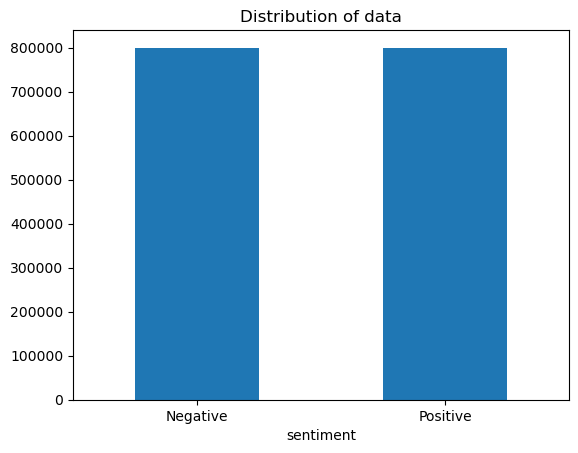

In [3]:
#We plot our data.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
#The x-axis.
ax.set_xticklabels(['Negative','Positive'], rotation=0)

#Next we store these data into their corresponding lists.
text, sentiment = list(df['text']), list(df['sentiment'])

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [5]:
def preprocess(textData):
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    processedText = []
    for tweet in textData:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [6]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 45 seconds


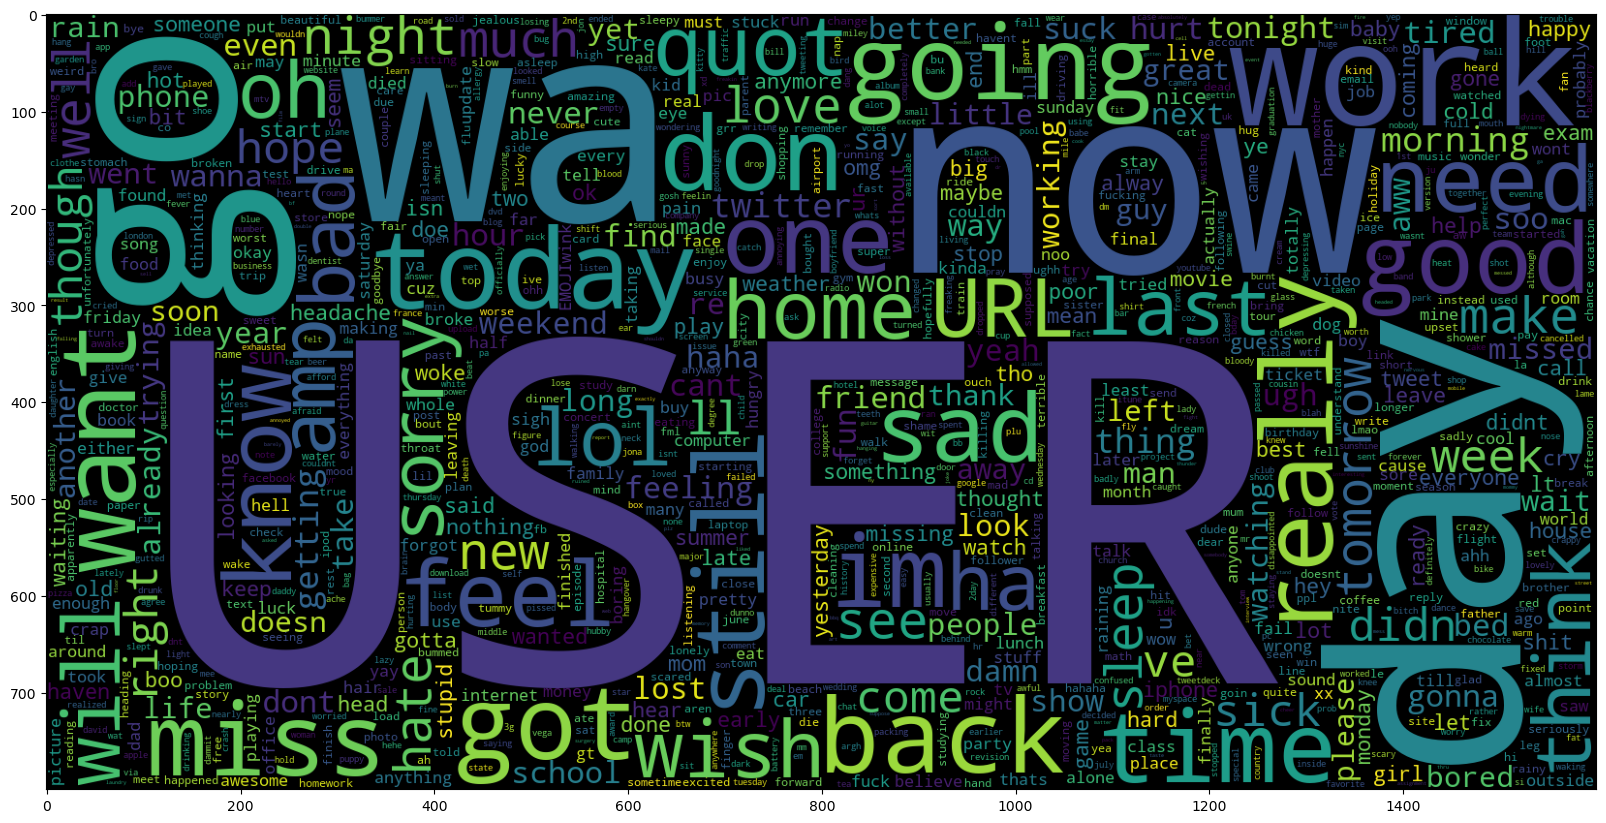

In [7]:
#We now do some basic analysis. 

#Word clouds
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

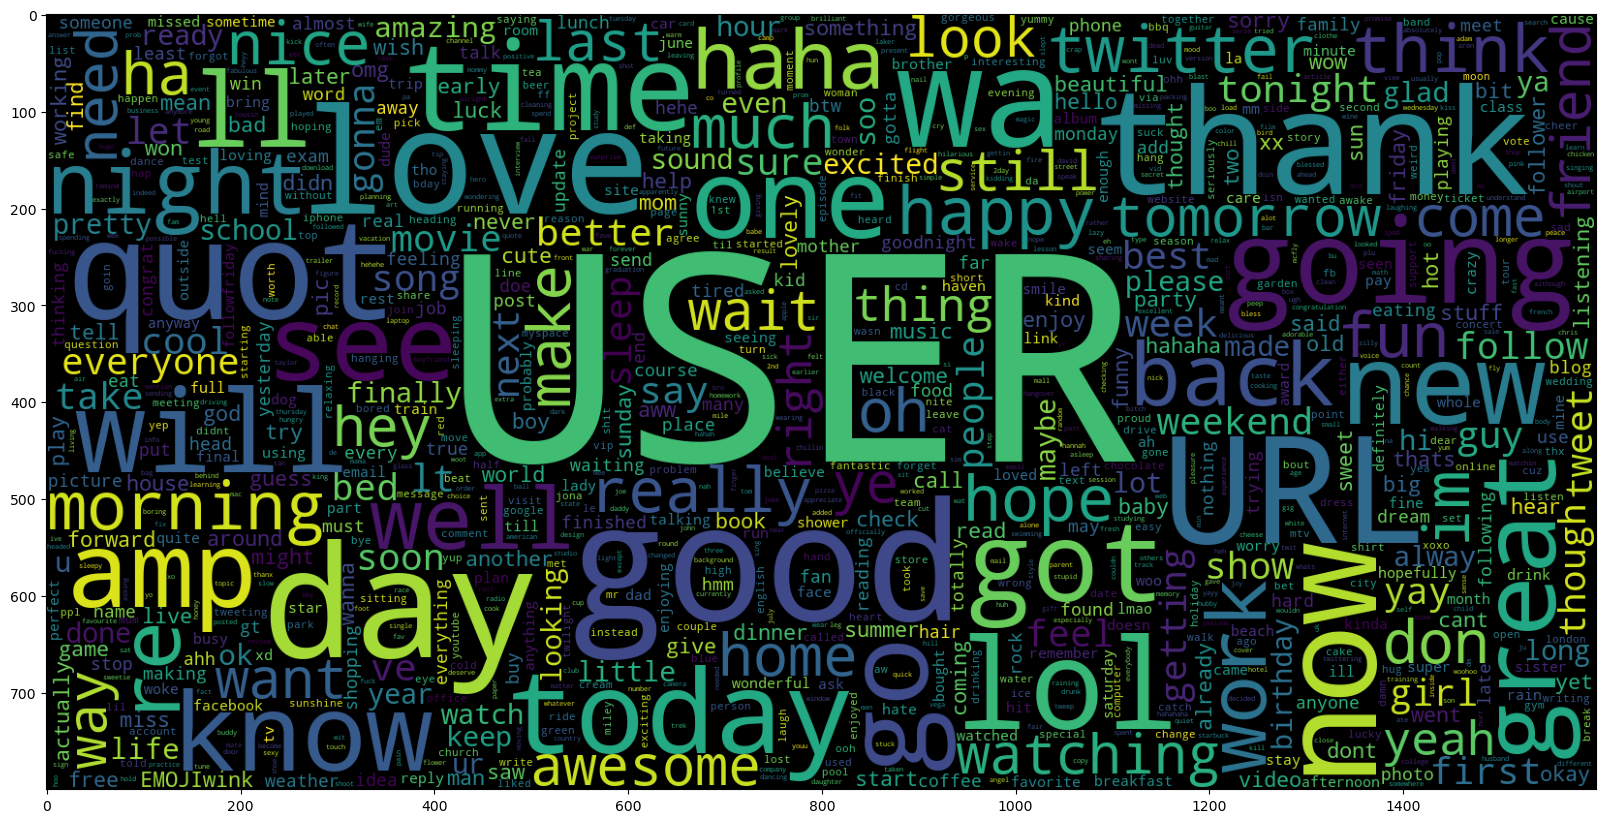

In [8]:
#Word cloud positive Tweets
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [9]:
#Next we split the data.
#Note that our test size is 5% while our train set is 95%
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0, train_size=10000)
print(f'Data Split done.')

Data Split done.


In [10]:
#TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.
#ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]
#max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus].


#Analysing the distribution of words and raking which would potentially be the most useful, like choosing 3 of the best words to be useful.
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  78567


In [11]:
#Tranforming the dataset
#Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [12]:
#Model evaluation.
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75     39989
           1       0.74      0.76      0.75     40011

    accuracy                           0.75     80000
   macro avg       0.75      0.75      0.75     80000
weighted avg       0.75      0.75      0.75     80000



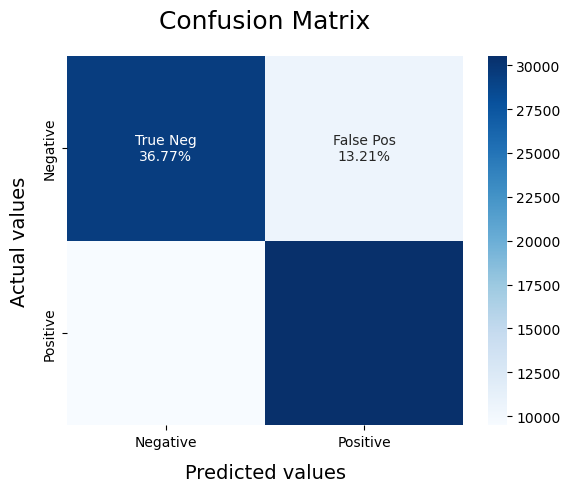

In [13]:
#Confusion matrix
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     39989
           1       0.76      0.75      0.75     40011

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



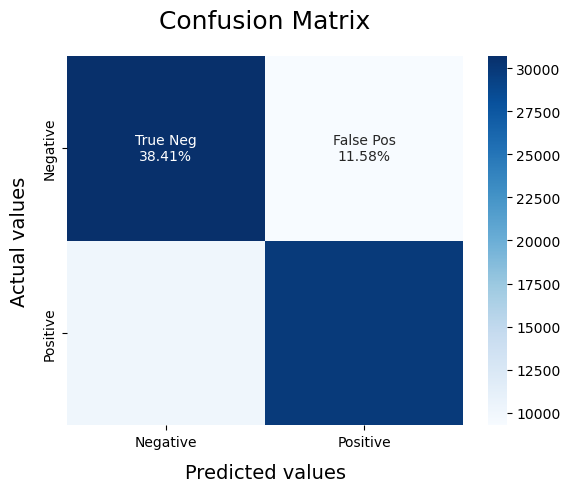

In [14]:
#Support Vector Classification.
SVCmodel = SVC(kernel='linear')
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.74      0.75      0.75     39989
           1       0.75      0.73      0.74     40011

    accuracy                           0.74     80000
   macro avg       0.74      0.74      0.74     80000
weighted avg       0.74      0.74      0.74     80000



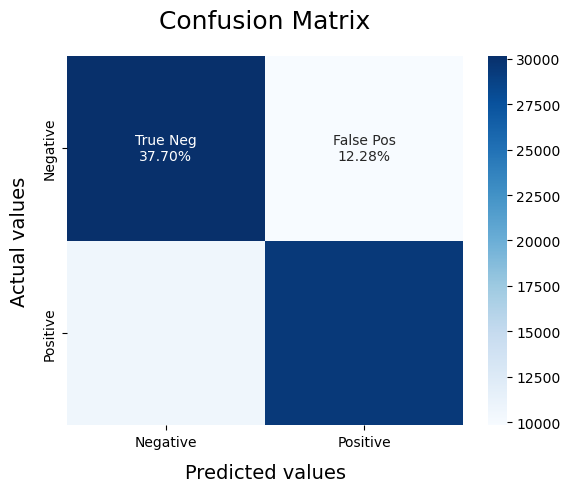

In [15]:
#Neural Networks.
NNModelL = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
NNModelL.fit(X_train, y_train)
model_Evaluate(NNModelL)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     39989
           1       0.77      0.74      0.75     40011

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000



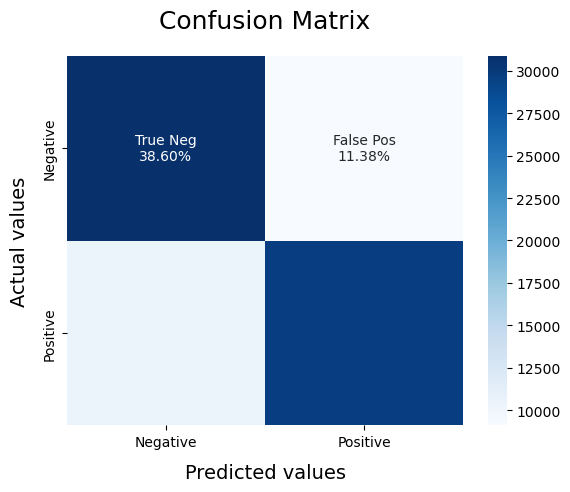

In [16]:
#Logistic Regression.
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [17]:
#We save the trainned model.
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-SVCmodel.pickle','wb')
pickle.dump(SVC, file)
file.close()

file = open('Sentiment-NNModelL.pickle','wb')
pickle.dump(MLPClassifier, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [18]:
#Reusing the model. And now predicting.

def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('..path/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('..path/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = [
            "Data science is cool",
            "Rudin is a crap maths book.",
            "Ram is an only child.",
            "I love Emilia.",
            "Don't become a web dev.",
            "The airspeed velocity!"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

                          text sentiment
0         Data science is cool  Positive
1  Rudin is a crap maths book.  Negative
2        Ram is an only child.  Negative
3               I love Emilia.  Positive
4      Don't become a web dev.  Negative
